**Step 1: Imports & Configuration**

In [1]:
!pip install torchcam --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.6 MB/s eta 0:00:00:00:0100:01


In [47]:
# PyTorch & core libraries
import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Torch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

# TorchVision models and transforms
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image

# Scikit-learn for CV & metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# TorchCAM for Grad-CAM visualization
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torch.nn.functional import softmax

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Data path and class names
DATA_DIR = "/kaggle/input/blood-cells-image-dataset/bloodcells_dataset"
TARGET_CLASSES = ['eosinophil', 'erythroblast', 'lymphocyte', 'neutrophil', 'platelet']

✅ Using device: cuda


**Step 2: Preprocessing & Dataset**

In [49]:
def get_transforms():
    """
    Returns two sets of image transforms:
    - Training: with augmentation
    - Test/Validation: basic resizing and normalization
    """
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    return train_transform, test_transform


class FilteredImageFolder(datasets.ImageFolder):
    """
    Custom ImageFolder that only loads selected WBC classes.
    Automatically remaps class indices to continuous 0-based labels.
    """
    def __init__(self, root, target_classes):
        super().__init__(root)
        self.class_to_idx = {cls: i for i, cls in enumerate(target_classes)}
        self.classes = target_classes
        valid_indices = [i for i, (_, lbl) in enumerate(self.samples) if self.targets[i] in list(self.class_to_idx.values())]
        self.samples = [self.samples[i] for i in valid_indices]
        self.targets = [s[1] for s in self.samples]


**3. Class Weights**

In [50]:
def compute_weights(dataset):
    """
    Computes inverse class frequency weights for CrossEntropyLoss.
    Handles class imbalance in the dataset.
    """
    labels = dataset.targets
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float32).to(device)

**4. Model Builder**

In [51]:
def create_model(num_classes):
    """
    Initializes ResNet-34 with pretrained ImageNet weights.
    Replaces final FC layer for custom classification.
    """
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

**5. K-Fold Training**

In [52]:
def train_kfold(base_ds, weights_tensor, transform_train, transform_test, k=5):
    """
    Runs stratified k-fold training with early stopping and weighted loss.
    Tracks and saves best-performing model for each fold.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    labels = base_ds.targets
    histories, best_overall = [], {'acc': 0, 'state': None, 'history': None, 'fold': None}

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
        print(f"\n📁 Fold {fold}")
        
        # Subset and transform per fold
        train_ds = Subset(base_ds, train_idx)
        val_ds = Subset(base_ds, val_idx)
        train_ds.dataset.transform = transform_train
        val_ds.dataset.transform = transform_test

        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

        # Model and training setup
        model = create_model(num_classes=len(base_ds.classes))
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)
        criterion = nn.CrossEntropyLoss(weight=weights_tensor)

        history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
        best_acc, no_improve = 0, 0

        # Training epochs
        for epoch in range(1, 31):
            model.train()
            total_loss = 0.0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward(); optimizer.step()
                total_loss += loss.item()

            # Validation phase
            model.eval()
            correct, total, val_loss = 0, 0, 0.0
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    val_loss += criterion(out, labels).item()
                    preds = out.argmax(1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            acc = correct / total
            history['train_loss'].append(total_loss / len(train_loader))
            history['val_loss'].append(val_loss / len(val_loader))
            history['val_acc'].append(acc)

            print(f"Epoch {epoch}: Train Loss={total_loss:.4f} | Val Acc={acc:.4%}")
            scheduler.step(acc)

            if acc > best_acc:
                best_acc, no_improve = acc, 0
                best_state = model.state_dict()
            else:
                no_improve += 1
                if no_improve >= 5:
                    print("🛑 Early stopping")
                    break

        # Save fold model
        os.makedirs("models", exist_ok=True)
        torch.save(best_state, f"models/fold{fold}_best.pth")

        if acc > best_overall['acc']:
            best_overall.update({'acc': acc, 'state': best_state, 'history': history, 'fold': fold})

    return best_overall, histories


**6. Evaluation & Metrics**

In [53]:
def evaluate_model(model, test_loader, class_names):
    """
    Computes accuracy, precision, recall and plots confusion matrix.
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

**7. Grad-CAM**

In [54]:
def show_gradcam(model, test_loader, class_names):
    """
    Visualizes Grad-CAM heatmap for a random test image.
    """
    model.eval()
    cam = GradCAM(model, target_layer='layer4')
    imgs, labels = next(iter(test_loader))
    idx = random.randint(0, len(imgs)-1)
    img = imgs[idx].unsqueeze(0).to(device)
    true_label = labels[idx].item()
    out = model(img)
    pred = out.argmax().item()
    activation = cam(pred, out)[0].cpu()

    img_vis = to_pil_image(img.squeeze().cpu() * 0.5 + 0.5)
    cam_overlay = overlay_mask(img_vis, to_pil_image(activation), alpha=0.5)

    plt.imshow(cam_overlay)
    plt.title(f"True: {class_names[true_label]} → Pred: {class_names[pred]}")
    plt.axis('off')
    plt.show()

**Run the main pipeline**

📂 Loaded 11559 images from /kaggle/input/blood-cells-image-dataset/bloodcells_dataset
🧪 Classes: ['eosinophil', 'erythroblast', 'lymphocyte', 'neutrophil', 'platelet']

📁 Fold 1
Epoch 1: Train Loss=47.2278 | Val Acc=99.1782%
Epoch 2: Train Loss=26.0985 | Val Acc=86.6782%
Epoch 3: Train Loss=18.7945 | Val Acc=92.9498%
Epoch 4: Train Loss=14.4866 | Val Acc=94.8097%
Epoch 5: Train Loss=5.4295 | Val Acc=99.8702%
Epoch 6: Train Loss=2.0604 | Val Acc=99.9135%
Epoch 7: Train Loss=1.7805 | Val Acc=99.9135%
Epoch 8: Train Loss=1.2728 | Val Acc=99.9135%
Epoch 9: Train Loss=1.2013 | Val Acc=99.9135%
Epoch 10: Train Loss=0.9777 | Val Acc=99.8702%
Epoch 11: Train Loss=0.6421 | Val Acc=99.9135%
🛑 Early stopping

📁 Fold 2
Epoch 1: Train Loss=45.7544 | Val Acc=98.9619%
Epoch 2: Train Loss=19.2859 | Val Acc=98.0969%
Epoch 3: Train Loss=16.0598 | Val Acc=99.5242%
Epoch 4: Train Loss=13.8590 | Val Acc=97.4913%
Epoch 5: Train Loss=14.6585 | Val Acc=98.1834%
Epoch 6: Train Loss=10.8474 | Val Acc=99.1349%
E

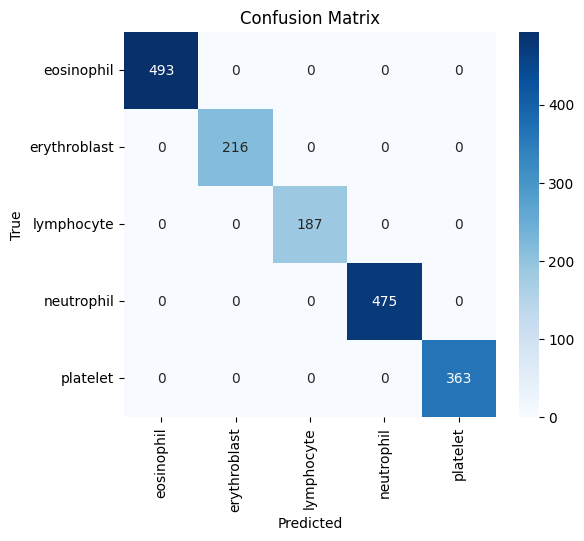

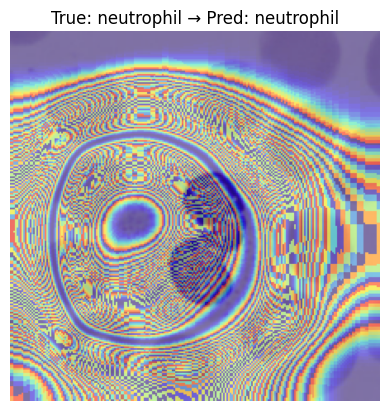

In [55]:
if __name__ == "__main__":
    # Step 1: Transforms
    train_tf, test_tf = get_transforms()

    # Step 2: Dataset loading
    base_ds = FilteredImageFolder(DATA_DIR, TARGET_CLASSES)
    print(f"📂 Loaded {len(base_ds)} images from {DATA_DIR}")
    print(f"🧪 Classes: {base_ds.classes}")

    # Step 3: Compute class weights
    weights_tensor = compute_weights(base_ds)

    # Step 4: K-Fold Training
    best_model_info, all_histories = train_kfold(base_ds, weights_tensor, train_tf, test_tf)

    # Step 5: Save best model
    torch.save(best_model_info['state'], "models/best_resnet34_final.pth")
    print(f"✅ Best model from Fold {best_model_info['fold']} saved!")

    # Step 6: Rebuild model and test split
    final_model = create_model(len(base_ds.classes))
    final_model.load_state_dict(best_model_info['state'])

    # Final test set evaluation
    _, test_ds = random_split(base_ds, [int(0.85 * len(base_ds)), len(base_ds) - int(0.85 * len(base_ds))],
                              generator=torch.Generator().manual_seed(42))
    test_ds.dataset.transform = test_tf
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # Step 7: Evaluate on test
    evaluate_model(final_model, test_loader, base_ds.classes)

    # Step 8: Grad-CAM
    show_gradcam(final_model, test_loader, base_ds.classes)
